In [1]:
import json
import logging
from collections import Counter
from itertools import product
from random import choice
from time import perf_counter
from typing import Literal, TypedDict

import numpy as np
from constants import DATA_DIR
from tqdm import tqdm

from astrofit.model import Asteroid, Lightcurve, LightcurveBin
from astrofit.utils import (
    AsteroidLoader,
    FrequencyDecomposer,
    LightcurveBinner,
    LightcurvePlotter,
    LightcurveSplitter,
)

In [2]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logger = logging.getLogger("freq")

logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")

In [3]:
asteroid_loader = AsteroidLoader(DATA_DIR)
frequency_decomposer = FrequencyDecomposer()
lightcurve_binner = LightcurveBinner()
lightcurve_plotter = LightcurvePlotter()
lightcurve_splitter = LightcurveSplitter()

FEATURES_DIR = DATA_DIR / "features"
ASTEROIDS_JSON_FILE_NAME = "asteroids_freq_data_{config_no}.json"


FEATURES_DIR.mkdir(exist_ok=True)

In [4]:
MAX_PERIOD = 40

asteroids: dict[str, Asteroid] = {}
for asteroid_name in tqdm(asteroid_loader.available_asteroids):
    ast_name = asteroid_loader.load_asteroid(asteroid_name)
    # if asteroid.period > MAX_PERIOD:
    #     continue

    asteroids[ast_name.name] = ast_name

print(f"Loaded {len(asteroids)} asteroids")

100%|██████████| 5057/5057 [00:14<00:00, 339.99it/s]

Loaded 5057 asteroids


In [5]:
np.percentile([asteroid.period for asteroid in asteroids.values()], [5, 25, 50, 75, 90, 95])

array([  3.422438,   5.48469 ,   8.78678 ,  16.97036 ,  49.0198  ,
       108.6936  ])

In [6]:
class Config(TypedDict):
    max_hours_diff: float
    min_no_points: int
    top_k_bins: int
    buffer_bins: int
    select_bins_by: Literal["lightcurves", "points"]
    max_time_diff: float
    min_bin_size: int
    max_freq: float
    top_k_freqs: int
    nterms: int
    max_debug: bool  # If true, will print and plot everything


In [7]:
cached_lightcurves: dict[tuple, dict[str, list[Lightcurve]]] = {}
cached_bins: dict[tuple, dict[str, list[LightcurveBin]]] = {}


def _split_lightcurves(asteroid: Asteroid, config: Config) -> list[Lightcurve]:
    max_hours_diff = config["max_hours_diff"]
    min_no_points = config["min_no_points"]

    logger.debug(
        f"Splitting lightcurves for {asteroid.name} with max_hours_diff={max_hours_diff} and min_no_points={min_no_points}"
    )
    logger.debug(f"Before splitting: {len(asteroid.lightcurves)} lightcurves")

    key = (max_hours_diff, min_no_points)
    if key in cached_lightcurves and asteroid.name in cached_lightcurves[key]:
        logger.debug(f"Using cached lightcurves ({key}) for {asteroid.name}")
        splitted = cached_lightcurves[key][asteroid.name]
    else:
        splitted = lightcurve_splitter.split_lightcurves(
            asteroid.lightcurves,
            max_hours_diff=max_hours_diff,
            min_no_points=min_no_points,
        )

        if key not in cached_lightcurves:
            cached_lightcurves[key] = {}

        cached_lightcurves[key][asteroid.name] = splitted

    logger.debug(f"After splitting: {len(splitted)} lightcurves")

    return splitted


def _get_top_k_bins(lightcurves: list[Lightcurve], config: Config, asteroid: Asteroid) -> list[LightcurveBin]:
    max_time_diff = config["max_time_diff"]
    min_bin_size = config["min_bin_size"]
    top_k_bins = config["top_k_bins"]
    buffer_bins = config["buffer_bins"]  # In case of too few frequencies for some of selected bins

    logger.debug(f"Getting top {top_k_bins} bins with max_time_diff={max_time_diff} and min_bin_size={min_bin_size}")

    # If using the same lightcurves AND the same binning parameters, we can reuse the bins
    composite_key = (config["max_hours_diff"], config["min_no_points"], max_time_diff, min_bin_size)
    if composite_key in cached_bins and asteroid.name in cached_bins[composite_key]:
        logger.debug(f"Using cached bins ({composite_key}) for {asteroid.name}")
        bins = cached_bins[composite_key][asteroid.name]
    else:
        bins = lightcurve_binner.bin_lightcurves(
            lightcurves,
            max_time_diff=max_time_diff,
            min_bin_size=min_bin_size,
        )

        if composite_key not in cached_bins:
            cached_bins[composite_key] = {}

        cached_bins[composite_key][asteroid.name] = bins

    logger.debug(f"After binning {len(bins)} bins available")
    if len(bins) < top_k_bins:
        logger.debug(f"Using {len(bins)} bins instead of {top_k_bins}")

    if config["select_bins_by"] == "lightcurves":
        return sorted(bins, reverse=True)[: top_k_bins + buffer_bins]

    elif config["select_bins_by"] == "points":
        return sorted(bins, key=lambda bin: bin.points_count, reverse=True)[: top_k_bins + buffer_bins]

    else:
        raise ValueError("Invalid value for select_bins_by")


def _get_top_k_freqs(lightcurve_bin: LightcurveBin, config: Config, asteroid: Asteroid) -> np.ndarray:
    nterms = config["nterms"]
    top_k_freqs = config["top_k_freqs"]

    logger.debug(
        f"Getting top {top_k_freqs} frequencies with nterms={nterms} for "
        f"lightcurves={len(lightcurve_bin)} with total points={len(lightcurve_bin.times)}"
    )

    freq_data = frequency_decomposer.decompose_bin(
        lightcurve_bin,
        fourier_nterms=nterms,
        top_k=top_k_freqs,
        max_freq=config["max_freq"],
        show_plot=config["max_debug"],
    )

    if config["max_debug"]:
        # Return also the ratio of the frequency to the true frequency
        true_freq_ratio = freq_data[:, 0] / (24 / asteroid.period)
        return np.column_stack((freq_data, true_freq_ratio))
    else:
        return freq_data


def _has_anomalous_series(data: list[list[float]], magnitude_threshold: int = 2):
    if not data:
        return False

    medians = np.array([np.median(series) for series in data])
    overall_median = np.median(medians)
    ratios = medians / overall_median

    anomalous_series_exist = np.any(np.logical_or(ratios > 10**magnitude_threshold, ratios < 10 ** (-magnitude_threshold)))

    return anomalous_series_exist


def get_freq_features(
    asteroid: Asteroid,
    config: Config,
) -> list[list] | dict:
    splitted_lightcurves = _split_lightcurves(asteroid, config)
    if _has_anomalous_series([lc.brightness_arr for lc in splitted_lightcurves]):
        logger.debug("Anomalous series detected")

        return {"status": "failed", "reason": "anomalous series"}

    # Includes buffer bins
    top_k_bins = _get_top_k_bins(splitted_lightcurves, config, asteroid)

    if not top_k_bins:
        logger.debug("No bins available")

        return {"status": "failed", "reason": "no bins"}

    top_k_bins_no = config["top_k_bins"]
    buffer_bins_no = config["buffer_bins"]

    freq_data = []
    for ind, _bin in enumerate(top_k_bins):
        if len(freq_data) == top_k_bins_no:
            break

        if ind >= top_k_bins_no:
            logger.debug(f"Using buffer bin {ind - top_k_bins_no + 1} / {buffer_bins_no}")

        if config["max_debug"]:
            lightcurve_plotter.plot_lightcurves(_bin)

        bin_freq = _get_top_k_freqs(_bin, config, asteroid)
        if len(bin_freq) < config["top_k_freqs"]:
            logger.debug(f"Bin {ind} has only {len(bin_freq)} frequencies, skipping")

            continue

        freq_data.append(bin_freq.tolist())

    if not freq_data:
        logger.debug("No frequencies available")

        return {"status": "failed", "reason": "no frequencies"}

    logger.debug(f"{'-'*50}\n")

    return freq_data

In [8]:
options = {
    "max_hours_diff": [1, 2, 4, 8],
    "min_no_points": [10, 20],
    "top_k_bins": [2, 4],
    "buffer_bins": [3],
    "select_bins_by": ["lightcurves", "points"],
    "max_time_diff": [30, 45, 60],
    "min_bin_size": [1, 2],
    "max_freq": [12],
    "top_k_freqs": [50],
    "nterms": [3],
    "max_debug": [False],
}

configs = []
for ind, option_values in enumerate(product(*options.values())):
    option = dict(zip(options.keys(), option_values))
    configs.append(Config(**option))

print(f"Generated {len(configs)} configurations")
print(f"Given ~4m per configuration, this will take ~{len(configs) * 4 / 60} hours")

Generated 192 configurations
Given ~4m per configuration, this will take ~12.8 hours


In [9]:
def calculate_and_save_features(config: Config, config_no: int):
    config["max_debug"] = False

    failed_cnt = 0
    asteroids_data = {}
    for asteroid_name, ast_name in tqdm(asteroids.items()):
        start = perf_counter()
        features = get_freq_features(ast_name, config)
        processing_time = perf_counter() - start

        asteroids_data[asteroid_name] = {
            "is_failed": False,
            "reason": None,
            "period": ast_name.period,
            "processing_time": processing_time,
            "features": [],
        }
        if isinstance(features, dict):
            failed_cnt += 1
            asteroids_data[asteroid_name]["is_failed"] = True
            asteroids_data[asteroid_name]["reason"] = features["reason"]
            continue

        assert len(features) in (1, 2, 3, 4), f"Invalid number of sequences: {len(features)} for {asteroid_name}"

        asteroids_data[asteroid_name]["features"] = features

    print(f"Failed asteroids: {failed_cnt} ({failed_cnt / len(asteroids) * 100:.2f}%)")
    print(f"{'-'*50}")

    dump_data = {
        "config": config,
        "asteroids": asteroids_data,
    }

    with open(FEATURES_DIR / (ASTEROIDS_JSON_FILE_NAME.format(config_no=config_no)), "w") as f:
        json.dump(dump_data, f, indent=4)

In [10]:
calculated_configs = []
for file in FEATURES_DIR.iterdir():
    if file.suffix != ".json":
        continue

    with open(file, "r") as f:
        data = json.load(f)
    
    calculated_configs.append(data["config"])

print(f"Already calculated {len(calculated_configs)} configurations")

Already calculated 112 configurations


In [11]:
logging.getLogger().setLevel(logging.INFO)

times = []
for ind, config in enumerate(configs):
    if config in calculated_configs:
        continue

    print(f"Config {ind + 1} / {len(configs)}")
    print(f"{'#'*10}")
    print(config)
    print(f"{'#'*10}")
    start = perf_counter()
    calculate_and_save_features(config, config_no=ind + 1)
    times.append(perf_counter() - start)

    print(f"Average time per configuration so far: {np.mean(times):.2f} seconds")
    print(f"{'-'*50}")

logging.getLogger().setLevel(logging.DEBUG)

Config 113 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [10:01<00:00,  8.40it/s]  


Failed asteroids: 4005 (79.20%)
--------------------------------------------------
Average time per configuration so far: 602.12 seconds
--------------------------------------------------
Config 114 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:47<00:00,  8.60it/s]  


Failed asteroids: 4100 (81.08%)
--------------------------------------------------
Average time per configuration so far: 595.24 seconds
--------------------------------------------------
Config 115 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [04:58<00:00, 16.94it/s]


Failed asteroids: 4052 (80.13%)
--------------------------------------------------
Average time per configuration so far: 496.47 seconds
--------------------------------------------------
Config 116 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [04:56<00:00, 17.03it/s]


Failed asteroids: 4148 (82.02%)
--------------------------------------------------
Average time per configuration so far: 446.67 seconds
--------------------------------------------------
Config 117 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:38<00:00, 11.02it/s]


Failed asteroids: 4024 (79.57%)
--------------------------------------------------
Average time per configuration so far: 449.20 seconds
--------------------------------------------------
Config 118 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:36<00:00, 11.07it/s]


Failed asteroids: 4119 (81.45%)
--------------------------------------------------
Average time per configuration so far: 450.53 seconds
--------------------------------------------------
Config 119 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:58<00:00,  8.45it/s]  


Failed asteroids: 4005 (79.20%)
--------------------------------------------------
Average time per configuration so far: 471.72 seconds
--------------------------------------------------
Config 120 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:57<00:00,  8.47it/s]  


Failed asteroids: 4100 (81.08%)
--------------------------------------------------
Average time per configuration so far: 487.43 seconds
--------------------------------------------------
Config 121 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [03:18<00:00, 25.49it/s] 


Failed asteroids: 4412 (87.25%)
--------------------------------------------------
Average time per configuration so far: 455.34 seconds
--------------------------------------------------
Config 122 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [03:16<00:00, 25.73it/s] 


Failed asteroids: 4498 (88.95%)
--------------------------------------------------
Average time per configuration so far: 429.48 seconds
--------------------------------------------------
Config 123 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:10<00:00, 16.31it/s]


Failed asteroids: 4410 (87.21%)
--------------------------------------------------
Average time per configuration so far: 418.65 seconds
--------------------------------------------------
Config 124 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:09<00:00, 16.33it/s]


Failed asteroids: 4496 (88.91%)
--------------------------------------------------
Average time per configuration so far: 409.58 seconds
--------------------------------------------------
Config 125 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:06<00:00, 11.84it/s]


Failed asteroids: 4409 (87.19%)
--------------------------------------------------
Average time per configuration so far: 410.94 seconds
--------------------------------------------------
Config 126 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:07<00:00, 11.83it/s]


Failed asteroids: 4495 (88.89%)
--------------------------------------------------
Average time per configuration so far: 412.15 seconds
--------------------------------------------------
Config 127 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [03:24<00:00, 24.77it/s] 


Failed asteroids: 4412 (87.25%)
--------------------------------------------------
Average time per configuration so far: 398.29 seconds
--------------------------------------------------
Config 128 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [03:24<00:00, 24.75it/s] 


Failed asteroids: 4498 (88.95%)
--------------------------------------------------
Average time per configuration so far: 386.18 seconds
--------------------------------------------------
Config 129 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:27<00:00, 15.43it/s]


Failed asteroids: 4410 (87.21%)
--------------------------------------------------
Average time per configuration so far: 382.76 seconds
--------------------------------------------------
Config 130 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:25<00:00, 15.52it/s]


Failed asteroids: 4496 (88.91%)
--------------------------------------------------
Average time per configuration so far: 379.62 seconds
--------------------------------------------------
Config 131 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:13<00:00, 11.66it/s]


Failed asteroids: 4409 (87.19%)
--------------------------------------------------
Average time per configuration so far: 382.47 seconds
--------------------------------------------------
Config 132 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:12<00:00, 11.69it/s]


Failed asteroids: 4495 (88.89%)
--------------------------------------------------
Average time per configuration so far: 384.98 seconds
--------------------------------------------------
Config 133 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [04:32<00:00, 18.54it/s]


Failed asteroids: 4412 (87.25%)
--------------------------------------------------
Average time per configuration so far: 379.65 seconds
--------------------------------------------------
Config 134 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [04:30<00:00, 18.68it/s]


Failed asteroids: 4498 (88.95%)
--------------------------------------------------
Average time per configuration so far: 374.71 seconds
--------------------------------------------------
Config 135 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [06:49<00:00, 12.36it/s]


Failed asteroids: 4410 (87.21%)
--------------------------------------------------
Average time per configuration so far: 376.23 seconds
--------------------------------------------------
Config 136 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [06:48<00:00, 12.38it/s]


Failed asteroids: 4496 (88.91%)
--------------------------------------------------
Average time per configuration so far: 377.58 seconds
--------------------------------------------------
Config 137 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:07<00:00,  9.24it/s]


Failed asteroids: 4409 (87.19%)
--------------------------------------------------
Average time per configuration so far: 384.37 seconds
--------------------------------------------------
Config 138 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:07<00:00,  9.23it/s]


Failed asteroids: 4495 (88.89%)
--------------------------------------------------
Average time per configuration so far: 390.67 seconds
--------------------------------------------------
Config 139 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [04:38<00:00, 18.15it/s]


Failed asteroids: 4412 (87.25%)
--------------------------------------------------
Average time per configuration so far: 386.53 seconds
--------------------------------------------------
Config 140 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [04:37<00:00, 18.22it/s]


Failed asteroids: 4498 (88.95%)
--------------------------------------------------
Average time per configuration so far: 382.65 seconds
--------------------------------------------------
Config 141 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:06<00:00, 11.86it/s]


Failed asteroids: 4410 (87.21%)
--------------------------------------------------
Average time per configuration so far: 384.16 seconds
--------------------------------------------------
Config 142 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:03<00:00, 11.93it/s]


Failed asteroids: 4496 (88.91%)
--------------------------------------------------
Average time per configuration so far: 385.49 seconds
--------------------------------------------------
Config 143 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:09<00:00,  9.20it/s]  


Failed asteroids: 4409 (87.19%)
--------------------------------------------------
Average time per configuration so far: 390.79 seconds
--------------------------------------------------
Config 144 / 192
##########
{'max_hours_diff': 4, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:09<00:00,  9.21it/s]  


Failed asteroids: 4495 (88.89%)
--------------------------------------------------
Average time per configuration so far: 395.75 seconds
--------------------------------------------------
Config 145 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [03:36<00:00, 23.35it/s]


Failed asteroids: 3337 (65.99%)
--------------------------------------------------
Average time per configuration so far: 390.34 seconds
--------------------------------------------------
Config 146 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [03:31<00:00, 23.90it/s]


Failed asteroids: 4117 (81.41%)
--------------------------------------------------
Average time per configuration so far: 385.09 seconds
--------------------------------------------------
Config 147 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:42<00:00, 14.76it/s]


Failed asteroids: 3311 (65.47%)
--------------------------------------------------
Average time per configuration so far: 383.89 seconds
--------------------------------------------------
Config 148 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:39<00:00, 14.91it/s]


Failed asteroids: 4086 (80.80%)
--------------------------------------------------
Average time per configuration so far: 382.65 seconds
--------------------------------------------------
Config 149 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:50<00:00, 10.76it/s]


Failed asteroids: 3292 (65.10%)
--------------------------------------------------
Average time per configuration so far: 385.02 seconds
--------------------------------------------------
Config 150 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:46<00:00, 10.85it/s]


Failed asteroids: 4066 (80.40%)
--------------------------------------------------
Average time per configuration so far: 387.16 seconds
--------------------------------------------------
Config 151 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [03:45<00:00, 22.43it/s]


Failed asteroids: 3337 (65.99%)
--------------------------------------------------
Average time per configuration so far: 383.03 seconds
--------------------------------------------------
Config 152 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [03:41<00:00, 22.82it/s]


Failed asteroids: 4117 (81.41%)
--------------------------------------------------
Average time per configuration so far: 379.00 seconds
--------------------------------------------------
Config 153 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:58<00:00, 14.12it/s]


Failed asteroids: 3311 (65.47%)
--------------------------------------------------
Average time per configuration so far: 378.51 seconds
--------------------------------------------------
Config 154 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:53<00:00, 14.29it/s]


Failed asteroids: 4086 (80.80%)
--------------------------------------------------
Average time per configuration so far: 377.92 seconds
--------------------------------------------------
Config 155 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:59<00:00, 10.55it/s]


Failed asteroids: 3292 (65.10%)
--------------------------------------------------
Average time per configuration so far: 380.30 seconds
--------------------------------------------------
Config 156 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:52<00:00, 10.70it/s]


Failed asteroids: 4066 (80.40%)
--------------------------------------------------
Average time per configuration so far: 382.41 seconds
--------------------------------------------------
Config 157 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:36<00:00, 15.02it/s]


Failed asteroids: 3337 (65.99%)
--------------------------------------------------
Average time per configuration so far: 381.40 seconds
--------------------------------------------------
Config 158 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:33<00:00, 11.15it/s]


Failed asteroids: 4117 (81.41%)
--------------------------------------------------
Average time per configuration so far: 382.98 seconds
--------------------------------------------------
Config 159 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [10:14<00:00,  8.23it/s]  


Failed asteroids: 3311 (65.47%)
--------------------------------------------------
Average time per configuration so far: 387.91 seconds
--------------------------------------------------
Config 160 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [08:45<00:00,  9.63it/s]  


Failed asteroids: 4086 (80.80%)
--------------------------------------------------
Average time per configuration so far: 390.78 seconds
--------------------------------------------------
Config 161 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:55<00:00,  8.49it/s]  


Failed asteroids: 3292 (65.10%)
--------------------------------------------------
Average time per configuration so far: 394.97 seconds
--------------------------------------------------
Config 162 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:49<00:00,  8.58it/s]  


Failed asteroids: 4066 (80.40%)
--------------------------------------------------
Average time per configuration so far: 398.86 seconds
--------------------------------------------------
Config 163 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:02<00:00, 16.72it/s]


Failed asteroids: 3337 (65.99%)
--------------------------------------------------
Average time per configuration so far: 396.98 seconds
--------------------------------------------------
Config 164 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [04:57<00:00, 17.02it/s]


Failed asteroids: 4117 (81.41%)
--------------------------------------------------
Average time per configuration so far: 395.07 seconds
--------------------------------------------------
Config 165 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:44<00:00, 10.90it/s]


Failed asteroids: 3311 (65.47%)
--------------------------------------------------
Average time per configuration so far: 396.38 seconds
--------------------------------------------------
Config 166 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:38<00:00, 11.04it/s]


Failed asteroids: 4086 (80.80%)
--------------------------------------------------
Average time per configuration so far: 397.53 seconds
--------------------------------------------------
Config 167 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [10:03<00:00,  8.38it/s]  


Failed asteroids: 3292 (65.10%)
--------------------------------------------------
Average time per configuration so far: 401.28 seconds
--------------------------------------------------
Config 168 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 10, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:57<00:00,  8.46it/s]  


Failed asteroids: 4066 (80.40%)
--------------------------------------------------
Average time per configuration so far: 404.80 seconds
--------------------------------------------------
Config 169 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [03:20<00:00, 25.28it/s] 


Failed asteroids: 4111 (81.29%)
--------------------------------------------------
Average time per configuration so far: 401.21 seconds
--------------------------------------------------
Config 170 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [03:16<00:00, 25.71it/s] 


Failed asteroids: 4492 (88.83%)
--------------------------------------------------
Average time per configuration so far: 397.69 seconds
--------------------------------------------------
Config 171 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:13<00:00, 16.14it/s]


Failed asteroids: 4109 (81.25%)
--------------------------------------------------
Average time per configuration so far: 396.26 seconds
--------------------------------------------------
Config 172 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:09<00:00, 16.33it/s]


Failed asteroids: 4490 (88.79%)
--------------------------------------------------
Average time per configuration so far: 394.82 seconds
--------------------------------------------------
Config 173 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:10<00:00, 11.75it/s]


Failed asteroids: 4108 (81.23%)
--------------------------------------------------
Average time per configuration so far: 395.41 seconds
--------------------------------------------------
Config 174 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:06<00:00, 11.85it/s]


Failed asteroids: 4489 (88.77%)
--------------------------------------------------
Average time per configuration so far: 395.92 seconds
--------------------------------------------------
Config 175 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [03:26<00:00, 24.47it/s] 


Failed asteroids: 4111 (81.29%)
--------------------------------------------------
Average time per configuration so far: 392.92 seconds
--------------------------------------------------
Config 176 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [03:24<00:00, 24.78it/s] 


Failed asteroids: 4492 (88.83%)
--------------------------------------------------
Average time per configuration so far: 389.97 seconds
--------------------------------------------------
Config 177 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:28<00:00, 15.40it/s]


Failed asteroids: 4109 (81.25%)
--------------------------------------------------
Average time per configuration so far: 389.03 seconds
--------------------------------------------------
Config 178 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [05:25<00:00, 15.51it/s]


Failed asteroids: 4490 (88.79%)
--------------------------------------------------
Average time per configuration so far: 388.07 seconds
--------------------------------------------------
Config 179 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:16<00:00, 11.60it/s]


Failed asteroids: 4108 (81.23%)
--------------------------------------------------
Average time per configuration so far: 388.79 seconds
--------------------------------------------------
Config 180 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:13<00:00, 11.66it/s]


Failed asteroids: 4489 (88.77%)
--------------------------------------------------
Average time per configuration so far: 389.46 seconds
--------------------------------------------------
Config 181 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [04:33<00:00, 18.47it/s]


Failed asteroids: 4111 (81.29%)
--------------------------------------------------
Average time per configuration so far: 387.79 seconds
--------------------------------------------------
Config 182 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [04:30<00:00, 18.66it/s]


Failed asteroids: 4492 (88.83%)
--------------------------------------------------
Average time per configuration so far: 386.12 seconds
--------------------------------------------------
Config 183 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [06:50<00:00, 12.31it/s]


Failed asteroids: 4109 (81.25%)
--------------------------------------------------
Average time per configuration so far: 386.48 seconds
--------------------------------------------------
Config 184 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [06:49<00:00, 12.34it/s]


Failed asteroids: 4490 (88.79%)
--------------------------------------------------
Average time per configuration so far: 386.80 seconds
--------------------------------------------------
Config 185 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:08<00:00,  9.21it/s]


Failed asteroids: 4108 (81.23%)
--------------------------------------------------
Average time per configuration so far: 389.03 seconds
--------------------------------------------------
Config 186 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:08<00:00,  9.22it/s]


Failed asteroids: 4489 (88.77%)
--------------------------------------------------
Average time per configuration so far: 391.19 seconds
--------------------------------------------------
Config 187 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [04:40<00:00, 18.05it/s]


Failed asteroids: 4111 (81.29%)
--------------------------------------------------
Average time per configuration so far: 389.71 seconds
--------------------------------------------------
Config 188 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [04:37<00:00, 18.26it/s]


Failed asteroids: 4492 (88.83%)
--------------------------------------------------
Average time per configuration so far: 388.23 seconds
--------------------------------------------------
Config 189 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:07<00:00, 11.83it/s]


Failed asteroids: 4109 (81.25%)
--------------------------------------------------
Average time per configuration so far: 388.75 seconds
--------------------------------------------------
Config 190 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 45, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [07:05<00:00, 11.90it/s]


Failed asteroids: 4490 (88.79%)
--------------------------------------------------
Average time per configuration so far: 389.21 seconds
--------------------------------------------------
Config 191 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:12<00:00,  9.16it/s]  


Failed asteroids: 4108 (81.23%)
--------------------------------------------------
Average time per configuration so far: 391.28 seconds
--------------------------------------------------
Config 192 / 192
##########
{'max_hours_diff': 8, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}
##########


100%|██████████| 5057/5057 [09:09<00:00,  9.21it/s]


Failed asteroids: 4489 (88.77%)
--------------------------------------------------
Average time per configuration so far: 393.26 seconds
--------------------------------------------------


In [16]:
ast_name = asteroids["1177 T-3"]
ast_name

Asteroid(id=19898, name=1177 T-3, period=2.557692, lightcurves=2)

In [17]:
config = configs[0]

config['max_debug'] = True

In [18]:
data = get_freq_features(ast_name, config)

2024-07-19 10:24:09,273 - freq - DEBUG - Splitting lightcurves for 1177 T-3 with max_hours_diff=1 and min_no_points=10
2024-07-19 10:24:09,274 - freq - DEBUG - Before splitting: 2 lightcurves
2024-07-19 10:24:09,274 - freq - DEBUG - Using cached lightcurves ((1, 10)) for 1177 T-3
2024-07-19 10:24:09,274 - freq - DEBUG - After splitting: 0 lightcurves
2024-07-19 10:24:09,275 - freq - DEBUG - Getting top 2 bins with max_time_diff=30 and min_bin_size=1
2024-07-19 10:24:09,275 - freq - DEBUG - Using cached bins ((1, 10, 30, 1)) for 1177 T-3
2024-07-19 10:24:09,275 - freq - DEBUG - After binning 0 bins available
2024-07-19 10:24:09,276 - freq - DEBUG - Using 0 bins instead of 2
2024-07-19 10:24:09,276 - freq - DEBUG - No bins available


In [20]:
with open(FEATURES_DIR / (ASTEROIDS_JSON_FILE_NAME.format(config_no=1)), "r") as f:
    data = json.load(f)


asteroids_data = data["asteroids"]


In [21]:
failed_asteroids = filter(lambda x: x[1]["is_failed"], asteroids_data.items())


In [22]:
reasons = Counter([failed_asteroid["reason"] for _, failed_asteroid in failed_asteroids])
print(reasons)

Counter({'no bins': 3441, 'no frequencies': 773, 'anomalous series': 23})


In [23]:
diffs = {}
for asteroid_name, asteroid_data in asteroids_data.items():
    if asteroid_data["is_failed"]:
        continue

    target_freq = 24 / asteroid_data["period"]
    freqs = np.array(asteroid_data["features"])

    top_k_ratio = freqs[:,:,0] / target_freq
    min_diff = np.min(np.abs(top_k_ratio - 1))  # Closest to 1

    diffs[asteroid_name] = min_diff

In [24]:
percentiles = np.percentile(list(diffs.values()), [0, 5, 25, 50, 75, 95, 100])
percentiles

array([2.80992425e-06, 1.08534760e-04, 6.07905993e-04, 2.28275966e-03,
       1.18916738e-02, 3.67478798e-01, 2.67102837e+01])

In [25]:
selected_asteroids = {name: data for name, data in asteroids_data.items() if name in diffs and diffs[name] > percentiles[-2]}
len(selected_asteroids)

41

2024-07-19 10:24:58,150 - freq - DEBUG - Splitting lightcurves for Pobeda with max_hours_diff=1 and min_no_points=10
2024-07-19 10:24:58,150 - freq - DEBUG - Before splitting: 1 lightcurves
2024-07-19 10:24:58,151 - freq - DEBUG - After splitting: 2 lightcurves
2024-07-19 10:24:58,152 - freq - DEBUG - Getting top 2 bins with max_time_diff=30 and min_bin_size=1
2024-07-19 10:24:58,152 - freq - DEBUG - After binning 1 bins available
2024-07-19 10:24:58,152 - freq - DEBUG - Using 1 bins instead of 2


Asteroid(id=1908, name=Pobeda, period=149.97, lightcurves=1)
Target frequency: 0.16003200640128026


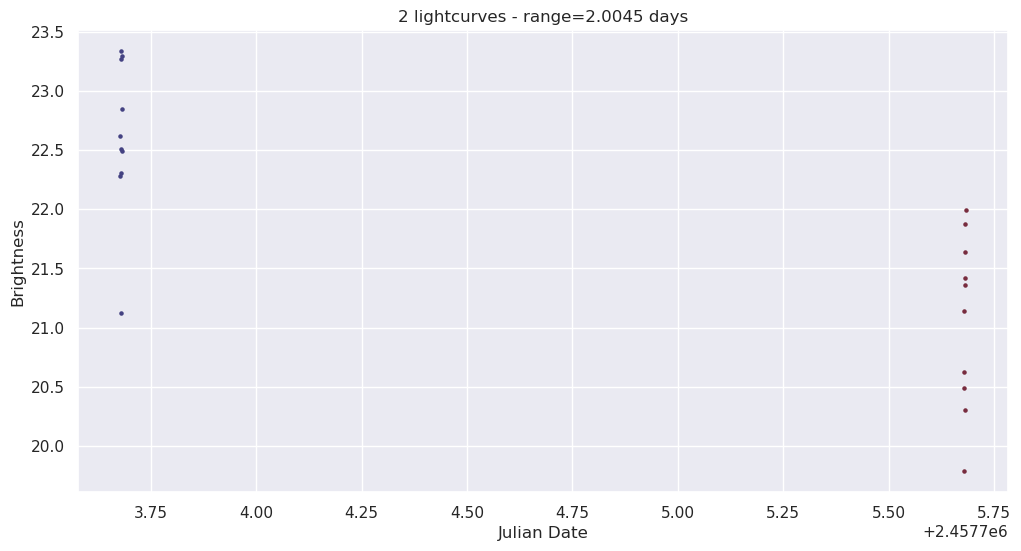

2024-07-19 10:24:58,331 - freq - DEBUG - Getting top 50 frequencies with nterms=3 for lightcurves=2 with total points=20


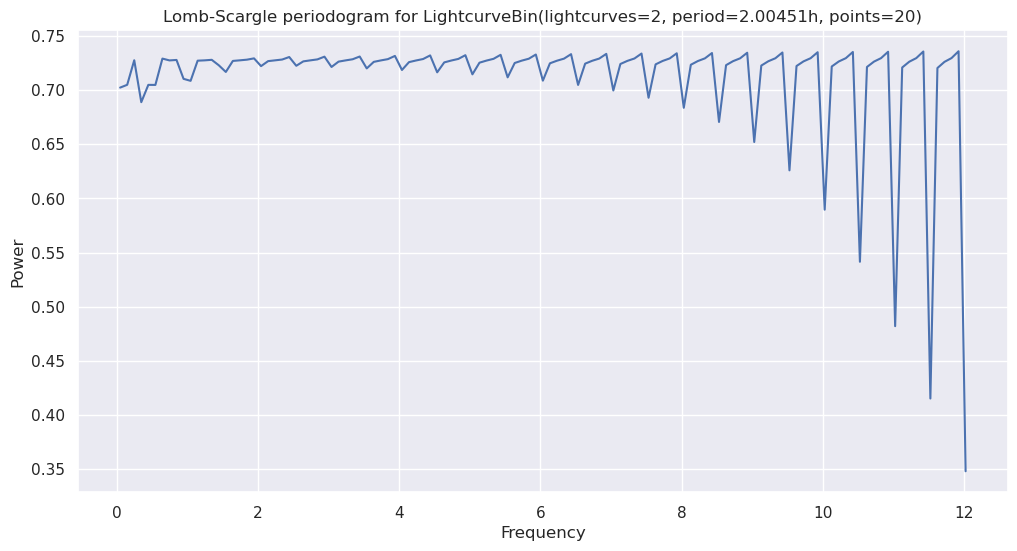

2024-07-19 10:24:58,482 - freq - DEBUG - --------------------------------------------------



[[[11.923113377259115, 0.7361058158884672, 74.5045547161479],
  [11.424238340553714, 0.7358745120078577, 71.38720933053501],
  [10.925363303848311, 0.7356521587457997, 68.26986394492214],
  [10.426488267142908, 0.7354289400897481, 65.15251855930924],
  [9.927613230437506, 0.7352021163402335, 62.035173173696364],
  [9.428738193732103, 0.7349501235415241, 58.91782778808348],
  [8.929863157026702, 0.7347248783734418, 55.8004824024706],
  [8.430988120321299, 0.7344514200215363, 52.683137016857714],
  [7.932113083615897, 0.7342111160600738, 49.565791631244835],
  [7.433238046910494, 0.7339750248819139, 46.44844624563195],
  [6.934363010205092, 0.733674650713823, 43.33110086001907],
  [6.43548797349969, 0.7334169132814612, 40.213755474406184],
  [5.936612936794288, 0.7330815062235382, 37.096410088793306],
  [5.4377379000888855, 0.7328067206442088, 33.97906470318042],
  [4.938862863383483, 0.7324611444877646, 30.86171931756754],
  [4.439987826678081, 0.732262335303525, 27.74437393195466],
  [

In [27]:
ast_name = choice(list(selected_asteroids.keys()))
print(repr(asteroids[ast_name]))
print(f"Target frequency: {24 / asteroids[ast_name].period}")

get_freq_features(asteroids[ast_name], config)